Shape: (96845, 8)
Columns: ['Year', 'Month_Name', 'Date', 'State', 'Vehicle_Class', 'Vehicle_Category', 'Vehicle_Type', 'EV_Sales_Quantity']
     Year Month_Name      Date           State         Vehicle_Class  \
0  2014.0        jan  1/1/2014  Andhra Pradesh       ADAPTED VEHICLE   
1  2014.0        jan  1/1/2014  Andhra Pradesh  AGRICULTURAL TRACTOR   
2  2014.0        jan  1/1/2014  Andhra Pradesh             AMBULANCE   
3  2014.0        jan  1/1/2014  Andhra Pradesh   ARTICULATED VEHICLE   
4  2014.0        jan  1/1/2014  Andhra Pradesh                   BUS   

  Vehicle_Category Vehicle_Type  EV_Sales_Quantity  
0           Others       Others                0.0  
1           Others       Others                0.0  
2           Others       Others                0.0  
3           Others       Others                0.0  
4              Bus          Bus                0.0  

Info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96845 entries, 0 to 96844
Data colum

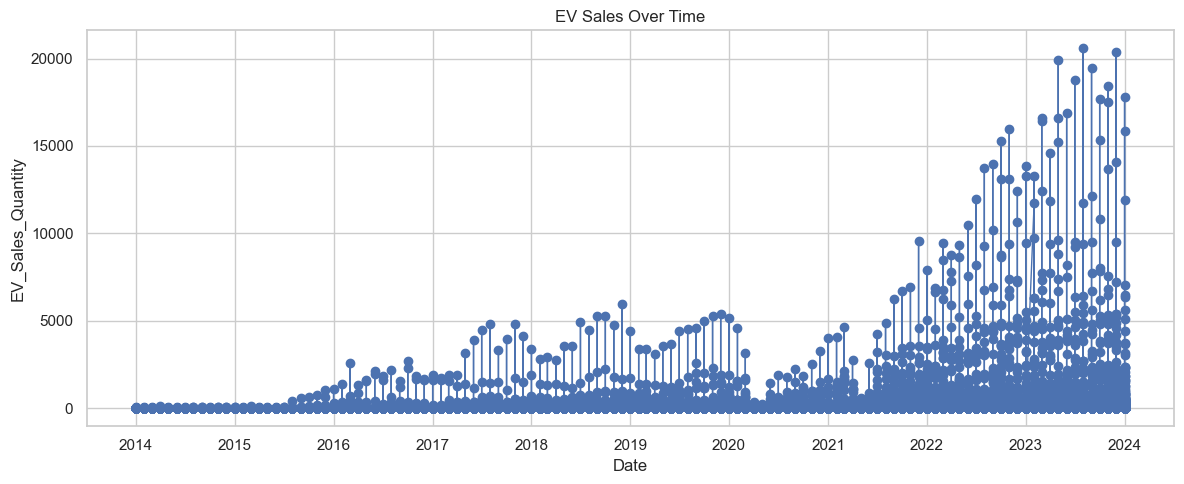

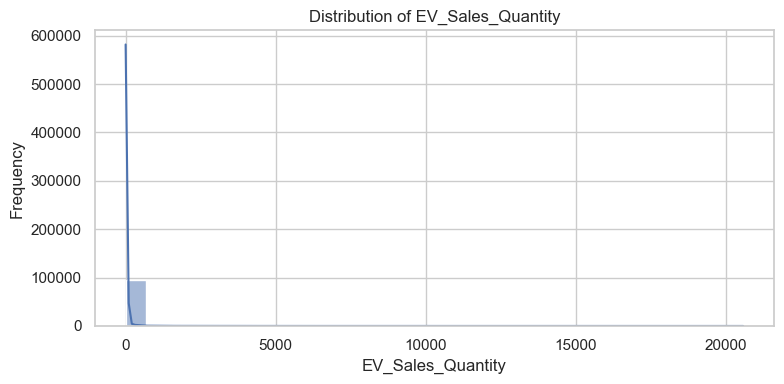

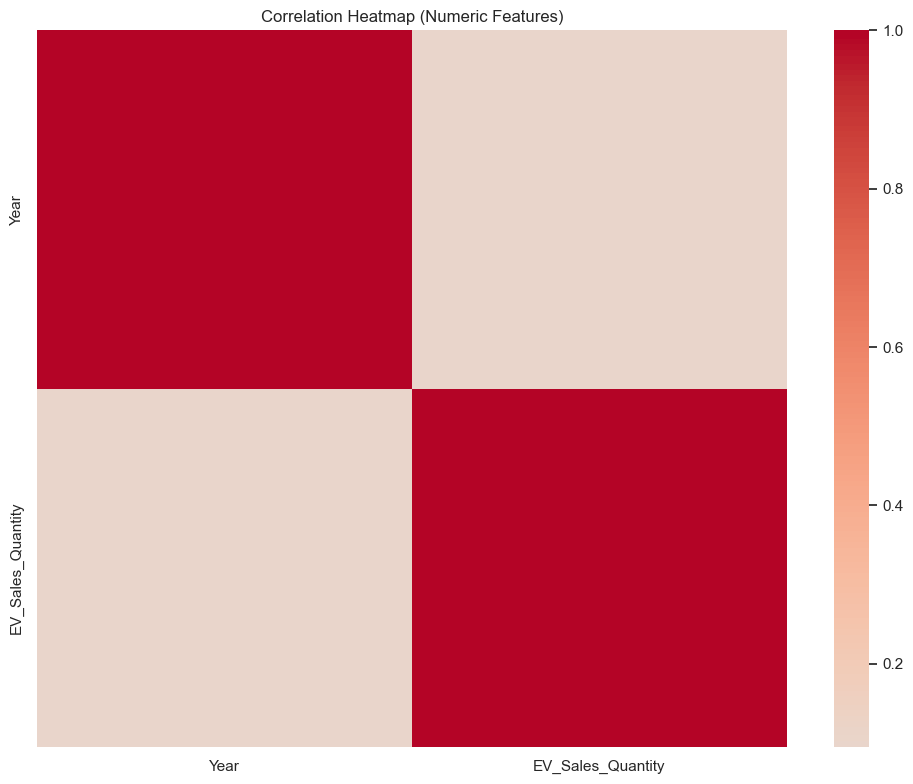

In [ ]:
# ===================== CONFIGURATION ===================== #
FILE_PATH  = "Downloads/ev_sales.csv"          # your EV sales CSV file
DATE_COL   = "Date"                  # from your columns
TARGET_COL = "EV_Sales_Quantity"     # from your columns
# ========================================================= #

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

sns.set(style="whitegrid")

# 1. DATA COLLECTION
df = pd.read_csv(FILE_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# 2. DATA PREPROCESSING
# 2.1 Convert date to datetime
if DATE_COL not in df.columns:
    raise ValueError(f"Date column '{DATE_COL}' not found. "
                     f"Available columns: {df.columns.tolist()}")
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# 2.2 Check target column
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. "
                     f"Available columns: {df.columns.tolist()}")

# 2.3 Drop rows with missing Date or target
df = df.dropna(subset=[DATE_COL, TARGET_COL])

# 2.4 Handle remaining missing values (numeric → median, categorical → mode)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COL in numeric_cols:
    numeric_cols.remove(TARGET_COL)

categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
if DATE_COL in categorical_cols:
    categorical_cols.remove(DATE_COL)

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode()[0])

print("\nInfo after cleaning:")
print(df.info())

# 3. EDA: trends and relationships
# 3.1 EV sales over time
df_sorted = df.sort_values(DATE_COL)

plt.figure(figsize=(12, 5))
plt.plot(df_sorted[DATE_COL], df_sorted[TARGET_COL], marker="o", linewidth=1)
plt.title("EV Sales Over Time")
plt.xlabel(DATE_COL)
plt.ylabel(TARGET_COL)
plt.tight_layout()
plt.show()

# 3.2 Distribution of EV sales
plt.figure(figsize=(8, 4))
sns.histplot(df[TARGET_COL], bins=30, kde=True)
plt.title(f"Distribution of {TARGET_COL}")
plt.xlabel(TARGET_COL)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 3.3 Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

# 4. FEATURE ENGINEERING
# 4.1 Date-based features
df["Year_NUM"]      = df[DATE_COL].dt.year
df["Month_NUM"]     = df[DATE_COL].dt.month
df["Day"]           = df[DATE_COL].dt.day
df["DayOfWeek"]     = df[DATE_COL].dt.dayofweek
df["Quarter"]       = df[DATE_COL].dt.quarter

# 4.2 Define features and target
feature_cols = [c for c in df.columns if c not in [DATE_COL, TARGET_COL]]

X = df[feature_cols]
y = df[TARGET_COL]

X_numeric = X.select_dtypes(include=[np.number]).columns.tolist()
X_categorical = X.select_dtypes(include=["object", "category"]).columns.tolist()

# 4.3 Preprocessor (numeric passthrough, categorical one-hot)
numeric_transformer = "passthrough"
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_numeric),
        ("cat", categorical_transformer, X_categorical),
    ]
)

# 5. MODELING: Random Forest Regressor
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", model),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)

# 6. EVALUATION
y_pred = pipeline.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print("\nModel performance:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R^2  : {r2:.3f}")

# 7. VISUALIZATION OF RESULTS
# 7.1 Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
plt.xlabel("Actual EV Sales Quantity")
plt.ylabel("Predicted EV Sales Quantity")
plt.title("Actual vs Predicted EV Sales Quantity")
plt.tight_layout()
plt.show()

# 7.2 Residual distribution
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 7.3 Feature importance
cat_feature_names = []
if len(X_categorical) > 0:
    ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(X_categorical)

feature_names = np.concatenate([X_numeric, cat_feature_names])
importances = pipeline.named_steps["model"].feature_importances_

fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
fi.head(20).plot(kind="bar")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
